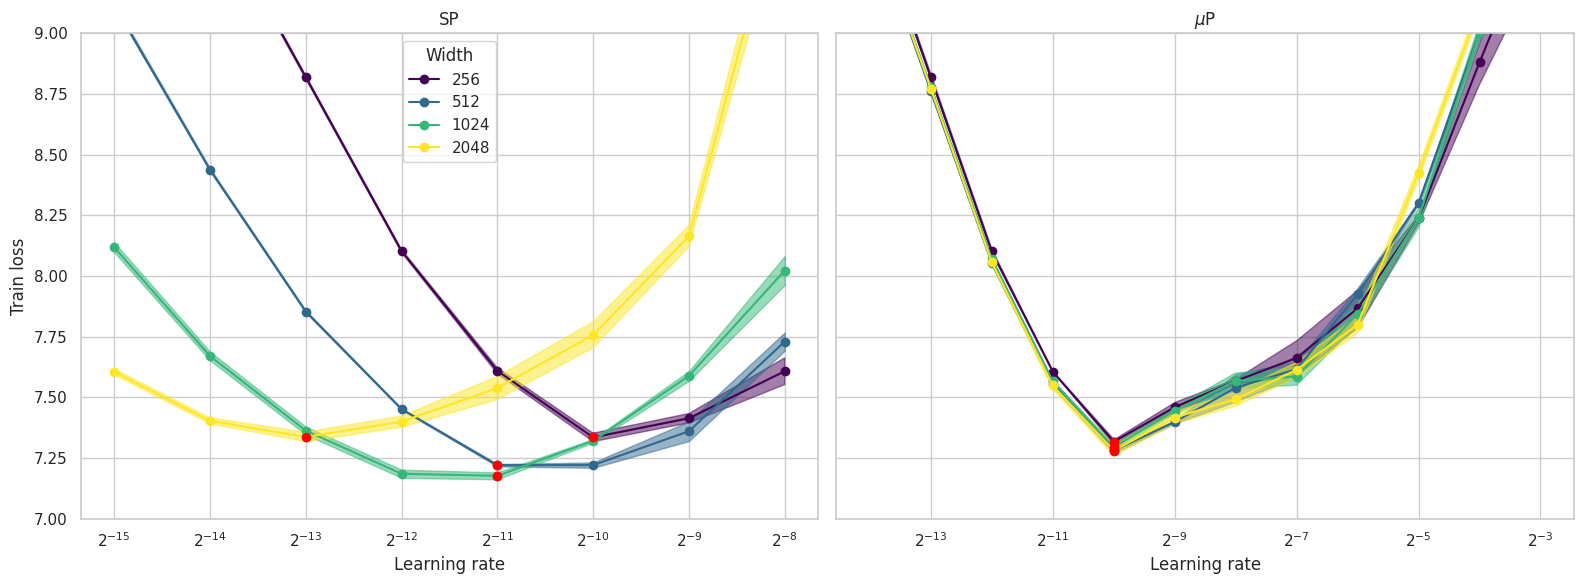

In [19]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
sns.set(style='whitegrid')

parameterizations = [
    ('sp', r'SP'),
    ('mup', r'$\mu$P'),
]
seeds = [1,2,3]
widths = [
    256,
    512,
    1024,
    2048,
]
lrs = [
    0.125,
    0.0625,
    0.03125,
    0.015625,
    0.0078125,
    0.00390625,
    0.001953125,
    0.0009765625,
    0.00048828125,
    0.000244140625,
    0.0001220703125,
    0.00006103515625,
    0.00003051757812,
]
class MplColorHelper:

    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)


color_helper = MplColorHelper('viridis', 0, len(widths)-1)
n_cols = 2#len(parameterizations)
n_rows = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 6*n_rows))
# axes = axes.reshape((n_rows, n_cols))

for parameterization_idx, (parameterization, parameterization_str) in enumerate(parameterizations):
    ax = axes[parameterization_idx]
    optimal_lrs = []
    optimal_losses = []
    for width_idx, width in enumerate(widths):
        mean_losses = []
        sem_losses = []
        lrs_to_plot = []
        for lr in lrs:
            losses = []
            for seed in seeds:
                job_name = f'width{width}_depth2_seed{seed}_lr{lr:.20f}'.rstrip('0')
                csv_path = os.path.join(parameterization, 'out', job_name, 'log.csv')
                if os.path.exists(csv_path):
                    ckpt_df = pd.read_csv(csv_path)
                    losses.append(ckpt_df['train/loss'].mean())
                    #print(losses)
                #else:
                    #print(f'Missing {csv_path}')
            if len(losses):
                mean_losses.append(np.mean(losses))
                sem_losses.append(np.std(losses, ddof=1) / np.sqrt(len(losses)))
                lrs_to_plot.append(lr)
        
        mean_losses = np.array(mean_losses)
        sem_losses = np.array(sem_losses)
        ax.plot(lrs_to_plot, mean_losses, label=width, marker='o', color=color_helper.get_rgb(width_idx))
        ax.fill_between(lrs_to_plot, mean_losses-sem_losses, mean_losses+sem_losses, color=color_helper.get_rgb(width_idx), alpha=0.5)
            
        if len(mean_losses):
            optimum_idx = np.argmin(mean_losses)
            optimal_lrs.append(lrs_to_plot[optimum_idx])
            optimal_losses.append(mean_losses[optimum_idx])
        
    ax.plot(optimal_lrs, optimal_losses, color='red', linestyle='none', marker='o')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Learning rate')
    ax.set_title(parameterization_str)
    ax.set_ylim(7, 9)

axes[0].legend(title='Width')
# axes[0].set_ylabel('Mean Train loss\nshakespeare_char')
axes[0].set_ylabel('Train loss')
axes[1].yaxis.set_ticklabels([])
axes[1].tick_params(axis='y', length=0, width=0)

plt.tight_layout()
plt.show()
plt.close()